In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import pickle as pkl
import imageio
import time
import os

In [2]:
def file_name(lattice_size,J,h,T,seed):
    return f'SQ_L_{lattice_size}_J_{J:.2f}_h_{h:.2f}_T_{T}_s_{seed}'


def read_data(lattice_size, J,h,T_init,T_final,seed,num_samples):
    TEMPERATURE_SCALE = 1000
    MAIN_DIRECTORY = "ising_data"
    # We define the T_index as the index number of the values of T
    # written in the file name, seperated by "_". So in this case e.g.
    # file_name = ...._T_1545_seed_1001 
    # index: 2 gives value of lattice size
    # index: 10 gives value of "seed"
    # index from last: 3 gives 1545 i.e. the value of T
    
    L_INDEX = 2
    J_INDEX = 4
    H_INDEX = 6
    T_INDEX = 8
    SEED_INDEX = 10

    # We scale up the T values to search and parse directories
    scale_up_T_init = T_init * TEMPERATURE_SCALE
    scale_up_T_final = T_final * TEMPERATURE_SCALE
    
    # Get a numpy array of all the subdirectories
    sub_directories = np.asarray([f.path for f in os.scandir(MAIN_DIRECTORY) if f.is_dir()])
    # Now we parse the T values from the directory names
    parsed_T_values = np.zeros(sub_directories.size)
    
    for dir_names in np.arange(sub_directories.size):
        # First we split the directory names with "_"
        sub_directories[dir_names] = sub_directories[dir_names].lstrip(MAIN_DIRECTORY + "/")
        split_directory_name = np.asarray(sub_directories[dir_names].split("_"))
        # Now we take the file names that fit our needs
        condition = split_directory_name[L_INDEX].astype(int) == lattice_size and \
                    split_directory_name[J_INDEX].astype(float)==J and \
                    split_directory_name[H_INDEX].astype(float) == h and \
                    split_directory_name[SEED_INDEX].astype(int) == seed
        if condition:
            # Now we take the T values. 
            parsed_T_values[dir_names] = split_directory_name[T_INDEX]
    
    # Now we drop the values that are not in the [T_init,T_final] interval
    # First, all the values less than T_init will be changed to zero
    parsed_T_values[np.where(parsed_T_values<scale_up_T_init)]=0
    
    # Similarly, all the values greater than T_final will be changed to zero
    parsed_T_values[np.where(parsed_T_values>scale_up_T_final)]=0

    # Now we trim all the zeros, and make sure everything is sorted as integers
    # Since our file names are integeres
    parsed_T_values = np.trim_zeros(np.sort(parsed_T_values.astype(int)))
    os.chdir(MAIN_DIRECTORY)
    # Now we have everything needed to create our filenames and read it
    data = {}

    if parsed_T_values.size > num_samples:
        # Randomly choose among the T values we have
        random_indexes = np.random.choice(parsed_T_values.size, num_samples, replace=False)
        for files in np.arange(num_samples):
            random_T = parsed_T_values[random_indexes[files]]
            directory_name = file_name(lattice_size, J,h,random_T,seed)
            os.chdir(directory_name)
            key_name = str(random_T)
            open_file = open(directory_name + ".pkl",'rb')
            data_sample = pkl.load(open_file)
            data.update({key_name: data_sample})
            os.chdir('..')
    else:
        for files in np.arange(parsed_T_values.size):
            directory_name = file_name(lattice_size, J,h,parsed_T_values[files],seed)
            os.chdir(directory_name)
            key_name = str(parsed_T_values[files])
            open_file = open(directory_name + ".pkl",'rb')
            data_sample = pkl.load(open_file)
            data.update({key_name: data_sample})
            os.chdir('..')
    os.chdir("..")
    return data


def get_configurations(lattice_size, J,h,T_init,T_final,seed,num_samples):
    # First we get the data
    get_data = read_data(lattice_size, J,h,T_init,T_final,seed,num_samples)
    if get_data == []:
        print("There is no such data.")
        return None,None
    # Let us extract the keys i.e. temperatures (scaled up temperatures)
    keys = np.array(list(get_data.keys())).astype(int)
    # Initialize configurations array
    configurations = np.zeros((keys.size, get_data[f"%d"%keys[0]]['lattice_configuration'].shape[0] ,lattice_size, lattice_size))
    
    # We iterate to get all the configurations in one array  
    for i in np.arange(keys.size):
        configurations[i] = get_data[keys[i].astype(str)]['lattice_configuration']
        
    # Now first element of keys array, is the temperature of
    # the first element of configurations array.
    return keys, configurations

In [3]:
sub_directories = np.asarray([f.path for f in os.scandir("ising_data") if f.is_dir()])

In [4]:
temperatures, configurations = get_configurations(lattice_size = 128 ,
                                                  J = 1.0 ,
                                                  h = 0 ,
                                                  T_init = 1.0 ,
                                                  T_final = 3.52 ,
                                                  seed = 0 , 
                                                  num_samples = 2000)

for s in np.arange(1,45):
    temp, conf = get_configurations(lattice_size = 128 ,
                                                  J = 1.0 ,
                                                  h = 0 ,
                                                  T_init = 1.0 ,
                                                  T_final = 3.52 ,
                                                  seed = s , 
                                                  num_samples = 20000)
    configurations = np.concatenate([configurations,conf],axis=1)


In [5]:
configurations.shape

(5, 945, 128, 128)

In [6]:
temperatures

array([1000, 1630, 2260, 2890, 3520])

In [7]:
configurations[0].shape

(945, 128, 128)

In [8]:
945*5

4725

In [9]:
data = np.concatenate([configurations[0], configurations[1],configurations[2],configurations[3],configurations[4]],axis=0)

In [10]:
data.shape

(4725, 128, 128)

In [11]:
data_size = 945
temp_labels_0 = np.zeros(data_size)


In [12]:
temp_labels_1 = np.zeros(data_size)
temp_labels_1 = np.where(temp_labels_1==0,1,1)
temp_labels_2 = np.zeros(data_size)
temp_labels_2 = np.where(temp_labels_2==0,2,2)
temp_labels_3 = np.zeros(data_size)
temp_labels_3 = np.where(temp_labels_3==0,3,3)
temp_labels_4 = np.zeros(data_size)
temp_labels_4 = np.where(temp_labels_4==0,4,4)

In [13]:
labels = np.concatenate([temp_labels_0,temp_labels_1,temp_labels_2,temp_labels_3,temp_labels_4],axis=0)

In [14]:
labels.shape

(4725,)

In [15]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

data, labels = shuffle(data, labels)
data_train, data_test, labels_train, labels_test = train_test_split(data,labels, train_size = 0.70)

In [16]:
print("Number of Training Samples: ",data_train.shape)
print("Number of Test Samples: ",data_test.shape)

Number of Training Samples:  (3307, 128, 128)
Number of Test Samples:  (1418, 128, 128)


In [17]:
from keras import models 
from keras.models import Model

from keras import layers
from keras.utils import to_categorical 
from keras.optimizers import RMSprop, Adam

Using TensorFlow backend.
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py

In [18]:
labels_train = to_categorical(labels_train) 
labels_test = to_categorical(labels_test)

In [19]:
from sklearn.metrics import confusion_matrix

In [20]:
def plot_confusion_matrix_1(confusion_matrix):
    plt.imshow(confusion_matrix, cmap=plt.cm.Blues)
    plt.xlabel("Predicted labels")
    plt.ylabel("True labels")
    plt.xticks([], [])
    plt.yticks([], [])
    plt.title('Confusion Matrix ')
    plt.colorbar()
    plt.savefig("conf.png")
    plt.show()

In [21]:
def loss_function(mdl):
    plt.plot(mdl.history['loss'])
    plt.plot(mdl.history['val_loss'])
    plt.title("Model Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Test'])
    plt.savefig("loss.png")
    plt.show()
def accuracy(mdl):
    plt.plot(mdl.history['accuracy'])
    plt.plot(mdl.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train','Test'])
    plt.savefig("acc.png")
    plt.show()

In [22]:
data_train = data_train.reshape(data_train.shape[0],1,128,128)
data_test = data_test.reshape(data_test.shape[0],1,128,128)
input_shape = (1,128,128)

data_train, labels_train = shuffle(data_train, labels_train)
data_test, labels_test = shuffle(data_test, labels_test)

In [23]:
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dense, Dropout, Flatten, GlobalAveragePooling2D

In [24]:
# As usual we start by creating a sequential model
model_cnn = models.Sequential()

# We add the convolutional layer
model_cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last',input_shape=input_shape))
# The batch normalization: helping to generalize the training
model_cnn.add(BatchNormalization())
# Another convolutional layer
model_cnn.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
# Batch normalization
model_cnn.add(BatchNormalization())
# Pooling for reducing overfitting
model_cnn.add(MaxPooling2D(pool_size=(2, 2), strides=2, padding='same' ))
# We drop some neurons that will again help avoid overfitting
model_cnn.add(Dropout(0.25))

# We will add another series of the above with greater number of filters
model_cnn.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', strides=1, padding='same', data_format='channels_last'))
model_cnn.add(BatchNormalization())
model_cnn.add(Conv2D(filters=64, kernel_size=(3, 3), strides=1, padding='same', activation='relu', data_format='channels_last'))
model_cnn.add(BatchNormalization())
model_cnn.add(MaxPooling2D(pool_size=(2, 2), padding='same', strides=2))
model_cnn.add(Dropout(0.25))

# Flatten will convert our results to 1D type
model_cnn.add(Flatten())
model_cnn.add(Dense(512, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.25))
model_cnn.add(Dense(1024, activation='relu'))
model_cnn.add(BatchNormalization())
model_cnn.add(Dropout(0.5))
# We have the final output layer
model_cnn.add(Dense(5, activation='softmax'))

Instructions for updating:
Colocations handled automatically by placer.


In [25]:
model_cnn.compile(optimizer=RMSprop(learning_rate= 0.00001), loss="categorical_crossentropy", metrics=["accuracy"])

In [26]:
model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 128, 32)        36896     
_________________________________________________________________
batch_normalization_1 (Batch (None, 1, 128, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 128, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 1, 128, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 1, 64, 32)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 64, 32)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 64, 64)        

In [27]:
train_cnn = model_cnn.fit(data_train, labels_train,
          epochs=500,
          verbose=1,
          validation_data=(data_test, labels_test))

Instructions for updating:
Use tf.cast instead.
Train on 3307 samples, validate on 1418 samples
Epoch 1/500
3307/3307 [==============================] - 8s 2ms/step - loss: 2.4331 - accuracy: 0.2613 - val_loss: 1.7474 - val_accuracy: 0.2003
Epoch 2/500
3307/3307 [==============================] - 7s 2ms/step - loss: 2.0229 - accuracy: 0.3399 - val_loss: 2.1433 - val_accuracy: 0.2038
Epoch 3/500
3307/3307 [==============================] - 7s 2ms/step - loss: 1.8105 - accuracy: 0.3940 - val_loss: 1.8060 - val_accuracy: 0.2426
Epoch 4/500
3307/3307 [==============================] - 7s 2ms/step - loss: 1.6624 - accuracy: 0.4309 - val_loss: 1.3412 - val_accuracy: 0.3999
Epoch 5/500
3307/3307 [==============================] - 7s 2ms/step - loss: 1.5487 - accuracy: 0.4563 - val_loss: 1.1445 - val_accuracy: 0.4725
Epoch 6/500
3307/3307 [==============================] - 7s 2ms/step - loss: 1.4839 - accuracy: 0.4708 - val_loss: 1.0397 - val_accuracy: 0.5402
Epoch 7/500
3307/3307 [===========

3307/3307 [==============================] - 8s 2ms/step - loss: 0.4419 - accuracy: 0.8174 - val_loss: 0.3002 - val_accuracy: 0.8456
Epoch 56/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.4371 - accuracy: 0.8264 - val_loss: 0.2986 - val_accuracy: 0.8449
Epoch 57/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.4027 - accuracy: 0.8279 - val_loss: 0.2972 - val_accuracy: 0.8441
Epoch 58/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.4036 - accuracy: 0.8298 - val_loss: 0.2916 - val_accuracy: 0.8477
Epoch 59/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.3943 - accuracy: 0.8355 - val_loss: 0.2877 - val_accuracy: 0.8491
Epoch 60/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.4221 - accuracy: 0.8264 - val_loss: 0.2860 - val_accuracy: 0.8456
Epoch 61/500
3307/3307 [==============================] - 7s 2ms/step - loss: 0.4015 - accuracy: 0.8376 - val_loss: 0.2832 - val_accuracy

3307/3307 [==============================] - 8s 2ms/step - loss: 0.2463 - accuracy: 0.9017 - val_loss: 0.2196 - val_accuracy: 0.8914
Epoch 112/500
3307/3307 [==============================] - 8s 3ms/step - loss: 0.2533 - accuracy: 0.8923 - val_loss: 0.2181 - val_accuracy: 0.8900
Epoch 113/500
3307/3307 [==============================] - 9s 3ms/step - loss: 0.3078 - accuracy: 0.8778 - val_loss: 0.2183 - val_accuracy: 0.8900
Epoch 114/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.2703 - accuracy: 0.8884 - val_loss: 0.2177 - val_accuracy: 0.8914
Epoch 115/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.2515 - accuracy: 0.8987 - val_loss: 0.2191 - val_accuracy: 0.8949
Epoch 116/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.2603 - accuracy: 0.8933 - val_loss: 0.2188 - val_accuracy: 0.8921
Epoch 117/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.2739 - accuracy: 0.8866 - val_loss: 0.2161 - val_ac

Epoch 167/500
3307/3307 [==============================] - 7s 2ms/step - loss: 0.1774 - accuracy: 0.9344 - val_loss: 0.1982 - val_accuracy: 0.9034
Epoch 168/500
3307/3307 [==============================] - 7s 2ms/step - loss: 0.1638 - accuracy: 0.9305 - val_loss: 0.1985 - val_accuracy: 0.9027
Epoch 169/500
3307/3307 [==============================] - 7s 2ms/step - loss: 0.1868 - accuracy: 0.9280 - val_loss: 0.2000 - val_accuracy: 0.9041
Epoch 170/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.1638 - accuracy: 0.9311 - val_loss: 0.1990 - val_accuracy: 0.9041
Epoch 171/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.1668 - accuracy: 0.9362 - val_loss: 0.1985 - val_accuracy: 0.9027
Epoch 172/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.1639 - accuracy: 0.9301 - val_loss: 0.2009 - val_accuracy: 0.8977
Epoch 173/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.1616 - accuracy: 0.9341 - val_loss: 0

Epoch 223/500
3307/3307 [==============================] - 8s 3ms/step - loss: 0.1006 - accuracy: 0.9613 - val_loss: 0.2018 - val_accuracy: 0.9090
Epoch 224/500
3307/3307 [==============================] - 9s 3ms/step - loss: 0.0988 - accuracy: 0.9640 - val_loss: 0.2004 - val_accuracy: 0.9104
Epoch 225/500
3307/3307 [==============================] - 9s 3ms/step - loss: 0.1304 - accuracy: 0.9501 - val_loss: 0.1986 - val_accuracy: 0.9126
Epoch 226/500
3307/3307 [==============================] - 9s 3ms/step - loss: 0.1240 - accuracy: 0.9507 - val_loss: 0.2008 - val_accuracy: 0.9126
Epoch 227/500
3307/3307 [==============================] - 9s 3ms/step - loss: 0.1109 - accuracy: 0.9580 - val_loss: 0.2014 - val_accuracy: 0.9104
Epoch 228/500
3307/3307 [==============================] - 9s 3ms/step - loss: 0.1013 - accuracy: 0.9607 - val_loss: 0.2023 - val_accuracy: 0.9083
Epoch 229/500
3307/3307 [==============================] - 8s 3ms/step - loss: 0.1140 - accuracy: 0.9604 - val_loss: 0

Epoch 279/500
3307/3307 [==============================] - 9s 3ms/step - loss: 0.1004 - accuracy: 0.9631 - val_loss: 0.2118 - val_accuracy: 0.9055
Epoch 280/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0894 - accuracy: 0.9670 - val_loss: 0.2091 - val_accuracy: 0.9069
Epoch 281/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0873 - accuracy: 0.9692 - val_loss: 0.2096 - val_accuracy: 0.9076
Epoch 282/500
3307/3307 [==============================] - 8s 3ms/step - loss: 0.0690 - accuracy: 0.9749 - val_loss: 0.2116 - val_accuracy: 0.9062
Epoch 283/500
3307/3307 [==============================] - 9s 3ms/step - loss: 0.0926 - accuracy: 0.9686 - val_loss: 0.2064 - val_accuracy: 0.9076
Epoch 284/500
3307/3307 [==============================] - 8s 3ms/step - loss: 0.0784 - accuracy: 0.9692 - val_loss: 0.2131 - val_accuracy: 0.9069
Epoch 285/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.1007 - accuracy: 0.9646 - val_loss: 0

Epoch 335/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0706 - accuracy: 0.9740 - val_loss: 0.2104 - val_accuracy: 0.9126
Epoch 336/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0636 - accuracy: 0.9767 - val_loss: 0.2183 - val_accuracy: 0.9062
Epoch 337/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0828 - accuracy: 0.9728 - val_loss: 0.2164 - val_accuracy: 0.9090
Epoch 338/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0651 - accuracy: 0.9746 - val_loss: 0.2211 - val_accuracy: 0.9083
Epoch 339/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0665 - accuracy: 0.9746 - val_loss: 0.2219 - val_accuracy: 0.9076
Epoch 340/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0629 - accuracy: 0.9761 - val_loss: 0.2199 - val_accuracy: 0.9076
Epoch 341/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0544 - accuracy: 0.9803 - val_loss: 0

Epoch 391/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0574 - accuracy: 0.9800 - val_loss: 0.2226 - val_accuracy: 0.9090
Epoch 392/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0469 - accuracy: 0.9837 - val_loss: 0.2195 - val_accuracy: 0.9118
Epoch 393/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0641 - accuracy: 0.9770 - val_loss: 0.2230 - val_accuracy: 0.9097
Epoch 394/500
3307/3307 [==============================] - 8s 3ms/step - loss: 0.0491 - accuracy: 0.9809 - val_loss: 0.2251 - val_accuracy: 0.9090
Epoch 395/500
3307/3307 [==============================] - 8s 3ms/step - loss: 0.0454 - accuracy: 0.9840 - val_loss: 0.2249 - val_accuracy: 0.9097
Epoch 396/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0742 - accuracy: 0.9788 - val_loss: 0.2322 - val_accuracy: 0.9069
Epoch 397/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0545 - accuracy: 0.9806 - val_loss: 0

Epoch 447/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0706 - accuracy: 0.9767 - val_loss: 0.2314 - val_accuracy: 0.9097
Epoch 448/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0533 - accuracy: 0.9834 - val_loss: 0.2480 - val_accuracy: 0.9090
Epoch 449/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0312 - accuracy: 0.9882 - val_loss: 0.2309 - val_accuracy: 0.9111
Epoch 450/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0409 - accuracy: 0.9858 - val_loss: 0.2351 - val_accuracy: 0.9126
Epoch 451/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0427 - accuracy: 0.9855 - val_loss: 0.2381 - val_accuracy: 0.9090
Epoch 452/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0420 - accuracy: 0.9852 - val_loss: 0.2486 - val_accuracy: 0.9097
Epoch 453/500
3307/3307 [==============================] - 8s 2ms/step - loss: 0.0326 - accuracy: 0.9885 - val_loss: 0

In [28]:
train_cnn.history.keys()

dict_keys(['val_loss', 'val_accuracy', 'loss', 'accuracy'])

In [29]:
test_loss_cnn, test_acc_cnn = model_cnn.evaluate(data_test,labels_test)

1418/1418 [==============================] - 1s 579us/step


In [30]:
print("The accuracy of the model on the test set is ",100*test_acc_cnn, "%")

The accuracy of the model on the test set is  91.18476510047913 %


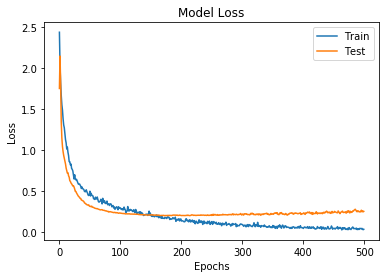

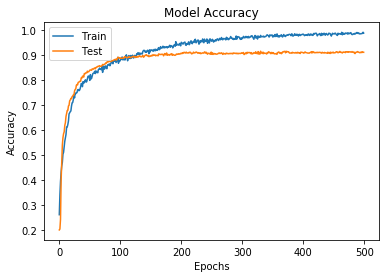

In [31]:
loss_function(train_cnn)
accuracy(train_cnn)

In [32]:
predictions_cnn = model_cnn.predict_classes(data_test)

In [33]:
rounded_labels_test =np.argmax(labels_test, axis=1)

In [36]:
confusion_matrix(rounded_labels_test, predictions_cnn)

array([[284,   0,   0,   0,   0],
       [  0, 280,   0,   0,   0],
       [  0,   5, 286,   0,   0],
       [  0,   0,   0, 184,  98],
       [  0,   0,   0,  22, 259]])

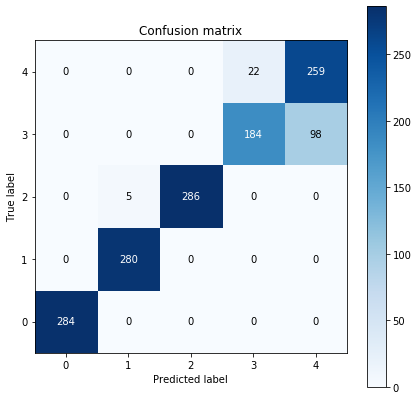

In [37]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(
        rounded_labels_test,
        predictions_cnn,
        figsize=(7, 7),title="Confusion matrix")

plt.ylim(-0.5, 4.5)
plt.savefig("confusion.png")
plt.show()